# Data processing
### 1. Imports

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### 2. Recuperation of the data in the csv files 

In [3]:
test_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PreTest-Scores.csv")).set_index('ID')
prof_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PreTest+ParticipantInfo.csv")).set_index('ID')

game_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-Game-ExtractedVariables.csv")).set_index('ID')
game_txt_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-Game-TextCoding.csv")).set_index('ID')

end_answer_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PostTest.csv")).set_index('ID')
end_txt_data = pd.DataFrame(pd.read_csv("../data/2023-07-17-1505-PostTest-TextCoding.csv")).set_index('ID')

### 3. Data analysis


#### 3.1. Splitting of the data by theme

In [4]:
# user information + result of the IRI and IPMQ tests
d_profile = pd.DataFrame({'group':prof_data['Group'] , 'gender':prof_data['StrataGender'], 'age':prof_data['pre_Age'], 'uni':prof_data['StrataUniv'], 'level':prof_data['StrataLevel'], 'ml':prof_data['MLScore_weighted'], 'ethics':prof_data['EthicsScore_weighted'], 'IPMQ':test_data['IPMQ-Score-scaled'], 'IRI':test_data['IRI-Score-scaled']})
d_profile = pd.get_dummies(d_profile) #one hot encoding

# decisions made during the game (no text, no emoji, no control group)
d_decisions = pd.DataFrame({'accept':game_data['menu1_answer'], 'jail_data': game_data['menu2_answer'], 'loop': game_data['looped'], 'translate_data':game_data['menu3_answer']})
d_decisions = d_decisions.replace({'STRAIGHT': 0.0,'0': 0.0,'0$0': 0.0,'0$1': 0.0, '0$1$0': 0.0, 'LOOPED': 1.0, '1': 1.0,'1$0': 1.0, '1$0$1': 1.0})

# themes recognized in the texts by the humans
d_game_text_themes = game_txt_data[game_txt_data['Group']=='ExpReflection'].drop(columns=['Group', 'jail_email', 'jail_reflection', 'Empty']).fillna(0.0)
d_end_text_themes = end_txt_data.drop(columns=['Group', 'post_Learned']).fillna(0.0)

#emoji of the users in one hot encoding
d_emoji = game_data[game_data.columns[game_data.columns.str.startswith('emoji')]].drop(columns=['emoji_answer','emojiJail_answer', 'emojiTranslator_all_answer'])

#all of the info
d_all = pd.concat([d_profile, d_decisions, d_game_text_themes, d_end_text_themes, d_emoji], axis=1)

### 3.2. Missing values

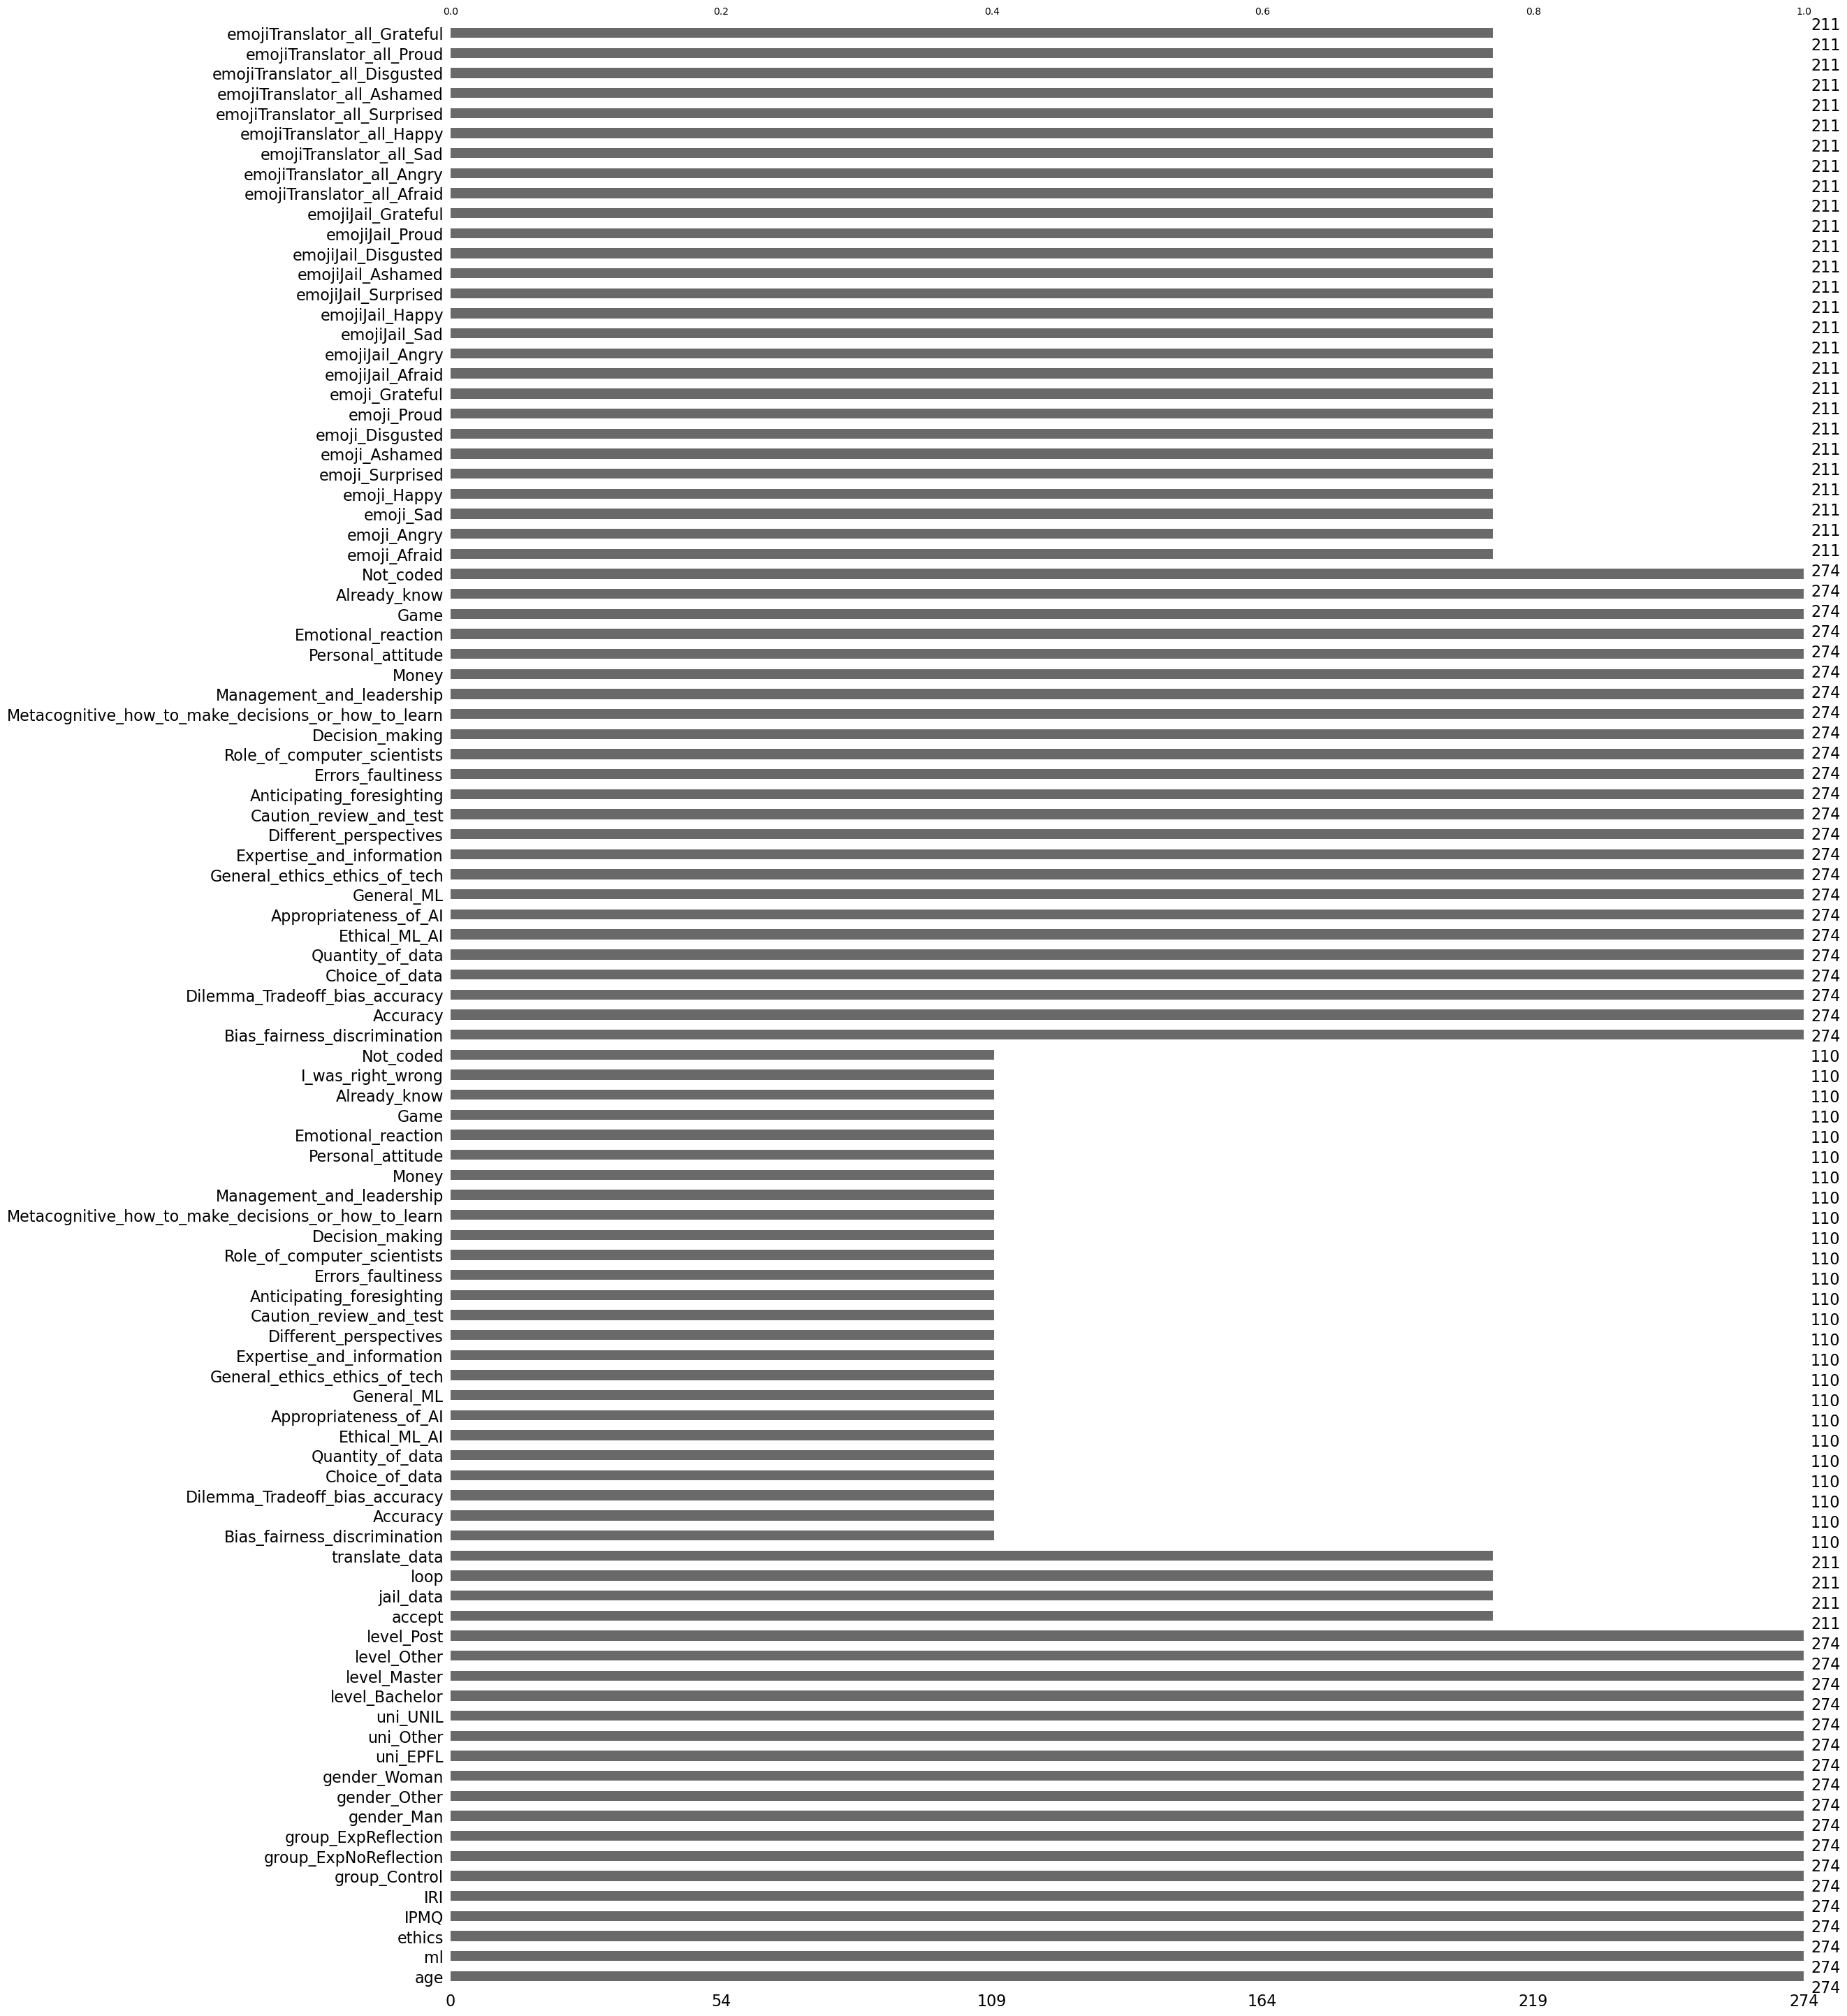

expected size for game_txt: 110
expected size for the decisions, emoji: 211
expected size for the profile, end_txt: 274


In [375]:
msno.bar(d_all)
plt.show()

control = (prof_data['Group'] == 'Control').sum()
reflexion = (prof_data['Group'] == 'ExpReflection').sum()
no_reflexion = (prof_data['Group'] == 'ExpNoReflection').sum()

print('expected size for game_txt:', reflexion)
print('expected size for the decisions, emoji:', reflexion + no_reflexion)
print('expected size for the profile, end_txt:', reflexion + no_reflexion + control)

We can observe that there are no missing values: each group has indeed the correct number of non-NaN entries

#### 3.3. Scaling

In [5]:
# Only for the continuous values -> the profile
scaler = MinMaxScaler().fit(d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']])
d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']] = scaler.transform(d_profile[['age', 'ml', 'ethics', 'IPMQ', 'IRI']])

### 4. Can the game be used to develop the ethical sensitivity of students in the domain of Machine Learning?


#### 4.1. Prediction of whether the student has learned about ethic or not

##### 4.1.1. Selection of the themes
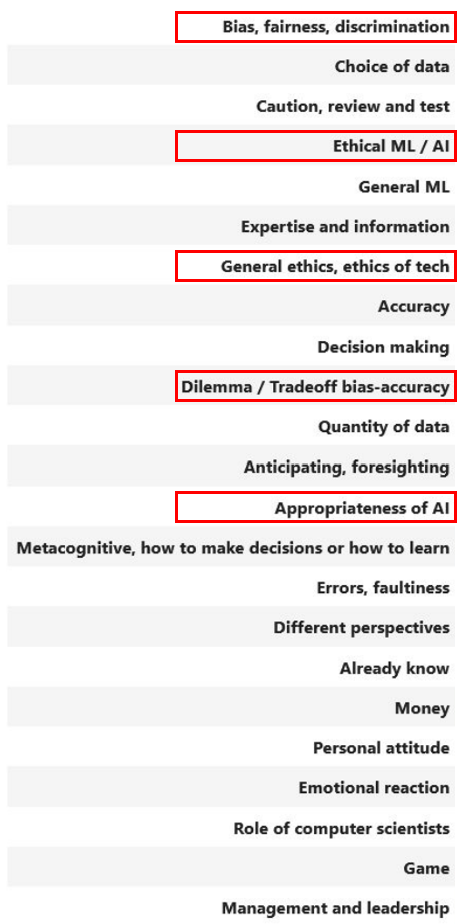

The student has learned about ethic if the end text contains one of the themes in red <br>
<img src="../images/ethic_themes.png" width="30%" height="30%">

In [452]:
# creation of the dataset
themes = d_end_text_themes[['Bias_fairness_discrimination', 'Ethical_ML_AI', 'General_ethics_ethics_of_tech', 'Dilemma_Tradeoff_bias_accuracy', 'Appropriateness_of_AI']].any(axis=1)

data = pd.concat([d_profile, themes], axis=1)

#remove groups
data = data.drop(['group_Control', 'group_ExpNoReflection', 'group_ExpReflection'], axis=1)

#over sampling
smote = SMOTE()
data_oversample = pd.concat(smote.fit_resample(data.iloc[:, :-1], data.iloc[:, -1]), axis=1)

##### 4.1.2 Selection of the model hyperparameters

In [300]:
# do the cross validation for a given model and parameter
def cross_validate(model_init_fun,  para_values, X, Y, cv=4, evaluation=accuracy_score):
    results = [(0, 0) for i in range(len(para_values))]
    for i in range(len(para_values)):
        model = model_init_fun(para_values[i])
        res = cross_val_score(model, X, Y, cv=cv, scoring=make_scorer(evaluation))
        results[i] = (np.mean(res), np.std(res))

    return results

In [301]:
def k_fold_cross_val_iter(para_values, model_init_fun, develop_data, test_data, evaluation=accuracy_score):

    X_dev = develop_data.iloc[:, :-1]
    Y_dev = develop_data.iloc[:, -1].astype('int32')

    X_test = test_data.iloc[:, :-1]
    Y_test = test_data.iloc[:, -1].astype('int32')

    #select best parameter
    result = cross_validate(model_init_fun, para_values, X_dev, Y_dev)
    best_para = para_values[np.argmax([i[0] for i in result])]
    best_std = result[np.argmax([i[0] for i in result])][1]

    #train best model on develop_data
    model = model_init_fun(best_para)
    model.fit(X_dev, Y_dev)

    #return the accuracy on the test set and the best parameter
    return (evaluation(Y_test, model.predict(X_test)), best_para, best_std)


In [404]:
def k_fold_cross_val(k, data):

    #split the data in k folds
    folds = np.split(data.sample(frac=1), (np.linspace(0, 1, k+1)[1:-1]*len(data)).astype('int32'))
    
    results_log = [(0, 0, 0) for i in range(k)]
    results_mlp = [(0, 0, 0) for i in range(k)]
    results_tree = [(0, 0, 0) for i in range(k)]

    #number of parameters to test
    nbr_para = 5

    #run k cross validations with k-1 folds and evaluate on the last one
    for i in range(k):
        test_data = folds[i]
        develop_data = pd.concat([folds[j] for j in range(k) if j != i])

        #logistic regression
        c_val = [10**(i-2) for i in range(nbr_para)]
        init = lambda c : LogisticRegression(penalty='l2', C=c, max_iter=500)
        results_log[i] = k_fold_cross_val_iter(c_val, init, develop_data, test_data, accuracy_score)

        #mlp
        hid_val = [10 + i*10 for i in range(nbr_para)]
        init = lambda hid : MLPClassifier(hidden_layer_sizes=(hid), activation='relu', max_iter=500, learning_rate_init=0.005)# was 0.05, alpha=0.001, learning_rate='constant')
        results_mlp[i] = k_fold_cross_val_iter(hid_val, init, develop_data, test_data, accuracy_score)

        #tree
        d = range(1, nbr_para+1)
        init = lambda d : tree.DecisionTreeClassifier(max_depth=d)
        results_tree[i] = k_fold_cross_val_iter(d, init, develop_data, test_data, accuracy_score) 

    return results_log, results_mlp, results_tree
        


In [409]:
results_log, results_mlp, results_tree = k_fold_cross_val(5, data_oversample)

c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [406]:
# helper to visualize the results of the cross validation
def show_nested_cross_val(results, model_name, para_name, para_scale='linear'):
    plt.scatter([i[1] for i in results], [i[0] for i in results], c=[i[2] for i in results], cmap='plasma')
    plt.xscale(para_scale)
    plt.colorbar(label='std')
    plt.xlabel(para_name)
    plt.ylabel('accuracy')
    plt.title('nested cross validation for ' + model_name)
    plt.show()

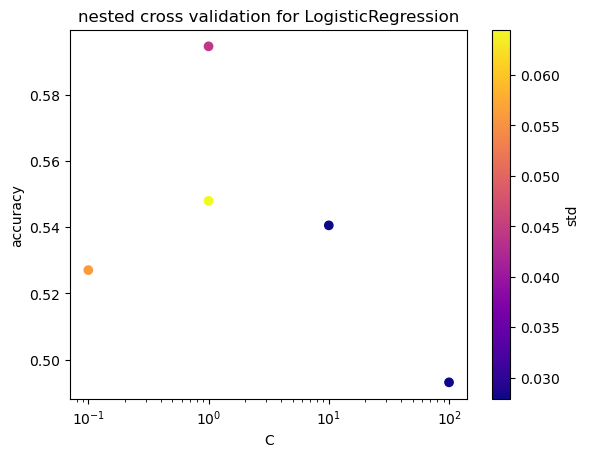

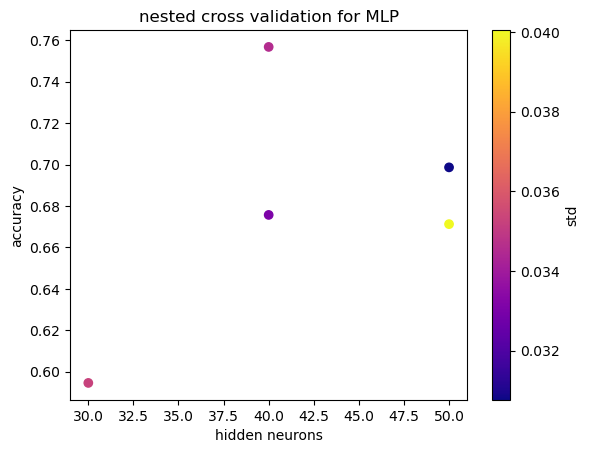

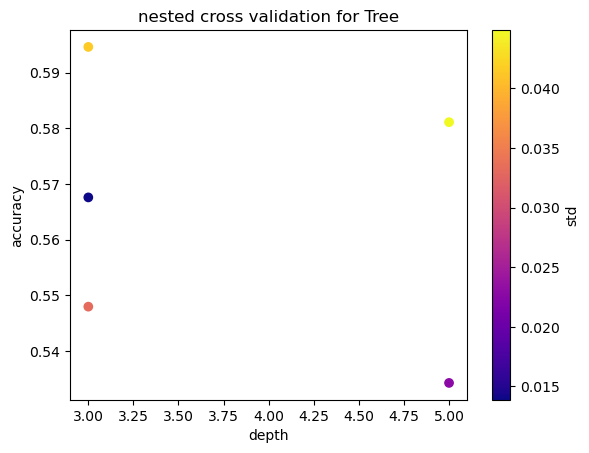

In [460]:
show_nested_cross_val(results_log, 'LogisticRegression', 'C', para_scale='log')
show_nested_cross_val(results_mlp, 'MLP', 'hidden neurons')
show_nested_cross_val(results_tree, 'Tree', 'depth')

#### 4.1.3 Visualisation of the best models

In [379]:
def show_res(model, Y, model_name, hyperparam_name, hyperparam_val):
    plt.bar(data.columns[:-1], Y)
    plt.xticks(rotation=90)
    accuracy = accuracy_score(Y_test, model.predict(X_test))
    plt.title("{model}[{hyp}={val}], accuracy = {acc}".format(model = model_name, acc = accuracy, hyp = hyperparam_name, val = hyperparam_val))
    plt.show()

(368, 16) (274, 16)
(258, 16) (0, 16)


,age,ml,ethics,IPMQ,IRI,gender_Man,gender_Other,gender_Woman,uni_EPFL,uni_Other,uni_UNIL,level_Bachelor,level_Master,level_Other,level_Post,0
ID,,,,,,,,,,,,,,,,
ac77f7a107e9406b912af6b689978f50,0.291667,0.500000,0.750,0.363636,0.431034,False,False,True,True,False,False,False,False,False,True,False
9414d01f4d9342098431e63dd7e0496e,0.291667,0.833333,0.375,0.545455,0.551724,True,False,False,True,False,False,False,True,False,False,True
77f0f10556b241dbb1711baf861cc63d,0.375000,0.000000,0.000,0.681818,0.551724,True,False,False,True,False,False,False,True,False,False,False
965840221e62415a9ad94593182af2ac,0.291667,0.000000,0.625,0.590909,0.672414,False,False,True,False,False,True,False,False,True,False,True
a02079ace5e94189a6f5ea8be6d6307d,0.208333,0.000000,0.375,0.363636,0.586207,False,False,True,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326b86f693a428ab7bd9d030b565bde,0.250000,0.333333,0.375,0.318182,0.655172,False,False,True,False,False,True,False,True,False,False,False
48dc0281d6be4b3d8866517496a102fa,0.041667,0.000000,0.250,0.590909,0.586207,False,False,True,False,False,True,True,False,False,False,True
78294b7bd8eb42b88062553d7398a2fc,0.166667,0.333333,0.375,0.272727,0.896552,False,False,True,False,False,True,True,False,False,False,True


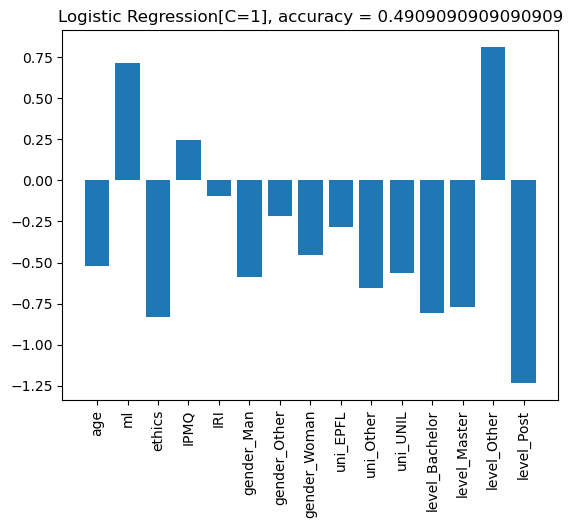

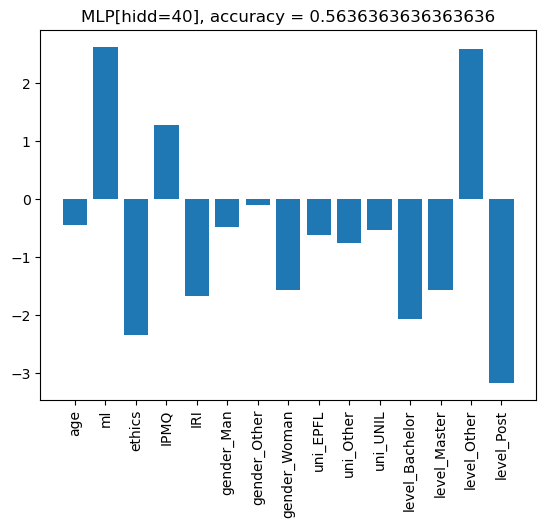

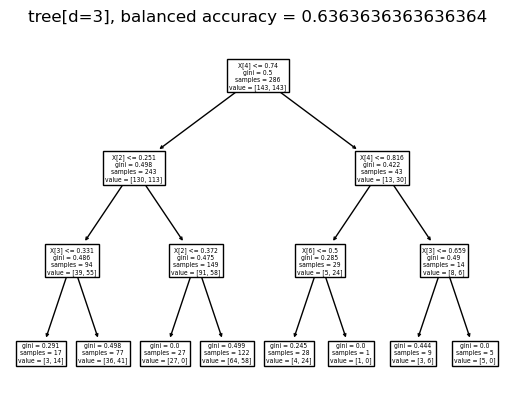

In [461]:
#best models
model_log = LogisticRegression(penalty='l2', C=1, max_iter=500)
model_mlp = MLPClassifier(hidden_layer_sizes=(40), activation='relu', max_iter=500, learning_rate_init=0.005, alpha=0.5)
model_tree = tree.DecisionTreeClassifier(max_depth=3)

#save 20% of the original data for testing
train_data, test_data = np.split(data.sample(frac=1), [int(.8*len(data))])
X_test = test_data.iloc[:, :-1]
Y_test = test_data.iloc[:, -1].astype('int32')

#oversample the rest of the original data and train the model with it
smote = SMOTE()
X_train, Y_train = smote.fit_resample(train_data.iloc[:, :-1], train_data.iloc[:, -1])

#training
model_log.fit(X_train, Y_train)
model_mlp.fit(X_train, Y_train)
model_tree.fit(X_train, Y_train)

#testing logistic regression
show_res(model_log, model_log.coef_.reshape(-1) , 'Logistic Regression', 'C', 1)

#testing mlp
features = len(data.columns)-1
x = np.zeros(features)
Y = np.zeros(features)
matrices = (model_mlp.coefs_)
for i in range(features):
    x[i-1] = 0
    x[i] = 1
    Y[i] = x @ matrices[0]@ matrices[1]
show_res(model_mlp, Y, 'MLP', 'hidd', 40)

#testing tree
tree.plot_tree(model_tree)
accuracy = accuracy_score(Y_test, model_tree.predict(X_test))
plt.title("{model}[d={depth}], balanced accuracy = {acc}".format(model = 'tree', acc = accuracy, depth = 3))
plt.show()



#### 4.1.3 Overfitting ?

c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum 

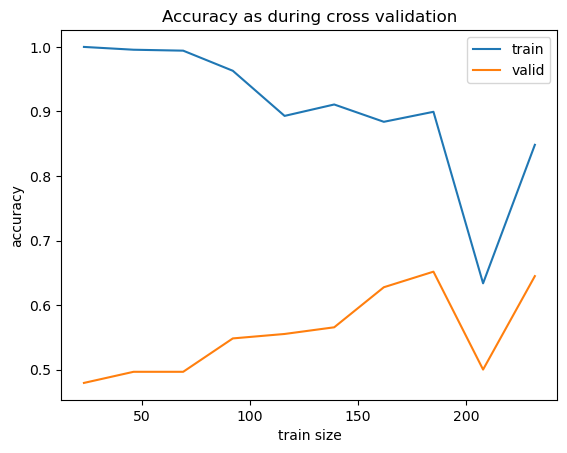

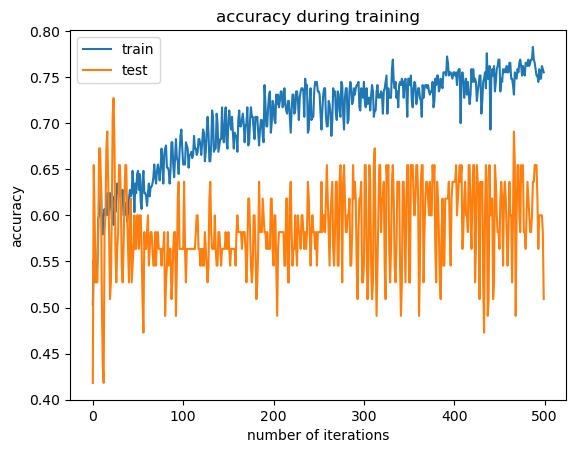

In [442]:
#accuracy during cross validation
model_mlp = MLPClassifier(hidden_layer_sizes=(40), activation='relu', max_iter=500, learning_rate_init=0.005, learning_rate='adaptive')

train_sizes, train_scores, valid_scores = learning_curve(model_mlp, X_train, Y_train, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], cv=5)

plt.plot(train_sizes,  train_scores.mean(axis=1), label='train')
plt.plot(train_sizes,  valid_scores.mean(axis=1), label='valid')
plt.xlabel('train size')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy as during cross validation')
plt.show()



#accuracy during training of the final model
n_epoch = 500
acc_train = np.zeros(n_epoch)
acc_test = np.zeros(n_epoch)

model_mlp = MLPClassifier(hidden_layer_sizes=(40), activation='relu', max_iter=500, learning_rate_init=0.01, learning_rate='adaptive', alpha=0.5)

for i in range(n_epoch):
    model_mlp.partial_fit(X_train, Y_train, classes=[0, 1])
    acc_train[i] = accuracy_score(Y_train, model_mlp.predict(X_train))
    acc_test[i] =  accuracy_score(Y_test, model_mlp.predict(X_test))


plt.plot(range(n_epoch), acc_train, label = 'train')
plt.plot(range(n_epoch), acc_test, label = 'test')
plt.title('accuracy during training')
plt.xlabel('number of iterations')
plt.ylabel('accuracy')
plt.legend()
plt.show()


#### 4.1.4 Confusion matrix

c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


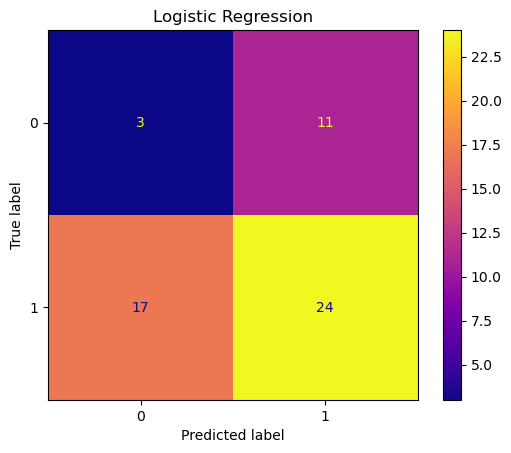

c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


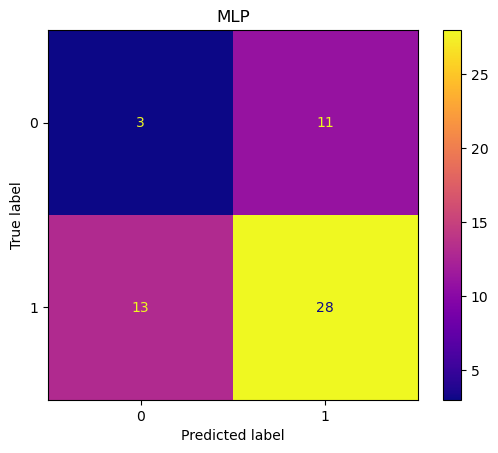

c:\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


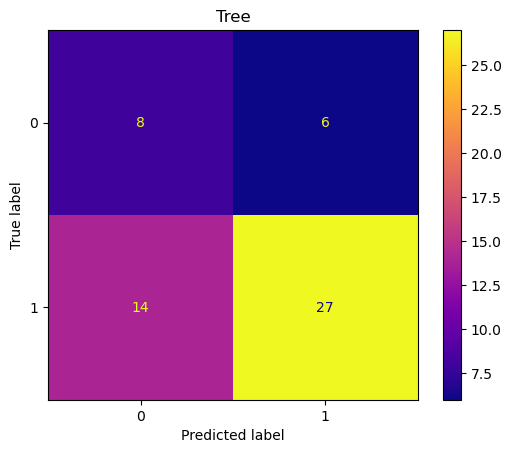

In [462]:
plot_confusion_matrix(model_log, X_test, Y_test, cmap='plasma')
plt.title('Logistic Regression')
plt.show()

plot_confusion_matrix(model_mlp, X_test, Y_test, cmap='plasma')
plt.title('MLP')
plt.show()

plot_confusion_matrix(model_tree, X_test, Y_test, cmap='plasma')
plt.title('Tree')
plt.show()

In [430]:
print(f1_score(Y_test, model_log.predict(X_test)))
print(f1_score(Y_test, model_mlp.predict(X_test)))
print(f1_score(Y_test, model_tree.predict(X_test)))


0.7567567567567567
0.7435897435897436
0.7027027027027026


In [100]:
not_learned = data[data.iloc[:, -1] == False].sample(n=20)
not_learned

,age,ml,ethics,IPMQ,IRI,gender_Man,gender_Other,gender_Woman,uni_EPFL,uni_Other,uni_UNIL,level_Bachelor,level_Master,level_Other,level_Post,0
ID,,,,,,,,,,,,,,,,
fdf53853a99541ac8b18effaa46f1302,0.250000,0.500000,0.375,0.227273,0.586207,True,False,False,True,False,False,False,True,False,False,False
d0a2c625c8204448a383b4c197d3b51b,0.125000,0.500000,0.375,0.409091,0.620690,False,False,True,False,False,True,True,False,False,False,False
c72ef634f7334d518c6b8897aaebc585,0.250000,0.000000,0.250,0.590909,0.741379,False,False,True,True,False,False,True,False,False,False,False
027bfc3abfef4d29981bcfc451ad4c0a,0.083333,0.333333,0.250,0.545455,0.689655,False,False,True,True,False,False,True,False,False,False,False
a3cb461f23834309a4b983769184ff00,0.416667,0.166667,0.250,1.000000,0.879310,False,False,True,False,False,True,False,True,False,False,False
759a334ab4d04ef2a0c3b6f143d4b084,0.041667,0.000000,0.375,0.545455,0.500000,False,False,True,False,False,True,True,False,False,False,False
3ef7199bb93f4969a925e8f22725e20f,0.083333,0.000000,0.250,0.500000,0.620690,False,False,True,True,False,False,True,False,False,False,False
11f309fc8b684738a11bb53c41d56429,0.041667,0.000000,0.000,0.500000,0.586207,True,False,False,False,False,True,True,False,False,False,False
f085f69418dd41c19cd26a63524a5f10,0.166667,0.000000,0.250,0.409091,0.517241,False,False,True,False,False,True,True,False,False,False,False


In [448]:
X_test

,age,ml,ethics,IPMQ,IRI,gender_Man,gender_Other,gender_Woman,uni_EPFL,uni_Other,uni_UNIL,level_Bachelor,level_Master,level_Other,level_Post
ID,,,,,,,,,,,,,,,
6a8990dddd6c43228a19d678b499d156,0.166667,0.166667,0.375,0.545455,0.534483,True,False,False,True,False,False,False,True,False,False
266eb359f1164710af825c1818ec084d,0.083333,0.000000,0.375,0.181818,0.086207,False,False,True,False,False,True,True,False,False,False
464a38a0e7f24f199ea3504da7276717,0.000000,0.000000,0.375,0.227273,0.465517,True,False,False,True,False,False,True,False,False,False
e0ba7f25dc7d4f64a552c70371ce3a11,0.166667,0.333333,0.625,0.681818,0.793103,False,False,True,True,False,False,True,False,False,False
ca1b0c9e064c4fe19843fc371e647a55,0.041667,0.166667,0.000,0.318182,0.379310,True,False,False,True,False,False,True,False,False,False
4cce9a533c554269857ad10a9328f181,0.125000,0.000000,0.375,0.636364,0.827586,False,False,True,True,False,False,False,True,False,False
22b9a88b32d246d38ad449a8a4369d4f,0.083333,0.333333,0.375,0.545455,0.637931,False,False,True,False,False,True,True,False,False,False
0bdfdba7b6e84b76983125a005e672b3,0.250000,0.000000,0.250,0.363636,0.482759,True,False,False,False,False,True,True,False,False,False
646b2dc00bb142ecb60969f4941ae80f,0.166667,0.000000,0.625,1.000000,0.637931,True,False,False,False,False,True,True,False,False,False


In [465]:
pip list

Package                       Version
----------------------------- --------------------
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.6.6
astropy                       5.1
asttokens                     2.0.5
async-generator               1.10
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcryp